<H2>課題3: 住宅価格の予測</H2>
<p>次は、統計モデリングの基礎を学習しましょう。</p>
<p>レッスン8までで学んだ内容を踏まえ、各セルに入っているコメントを実行するコードを記入してください。</p>

<H2>1. 必要なモジュールの読み込み</H2>

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline

<H2>2. データの読み込み</H2>
<p>pandasにはread_csvという関数が用意されており、それを用いれば簡単にCSVファイルを読み込むことができます。</p>

<p>データはdatasetフォルダ直下にある"kaggle_housing_price_revised.csv"を使用します。</p>

In [2]:
# データを読み込んで変数 data に格納
data = pd.read_csv("dataset/kaggle_housing_price_revised.csv")

In [3]:
# データの最初の5行だけ表示
data.head()

,Id,OverallQual,OverallCond,YearBuilt,BsmtFinSF1,FlrSF1st,FlrSF2nd,GrLivArea,SalePrice
0,1,7,5,2003,706,856,854,1710,208500
1,2,6,8,1976,978,1262,0,1262,181500
2,3,7,5,2001,486,920,866,1786,223500
3,4,7,5,1915,216,961,756,1717,140000
4,5,8,5,2000,655,1145,1053,2198,250000


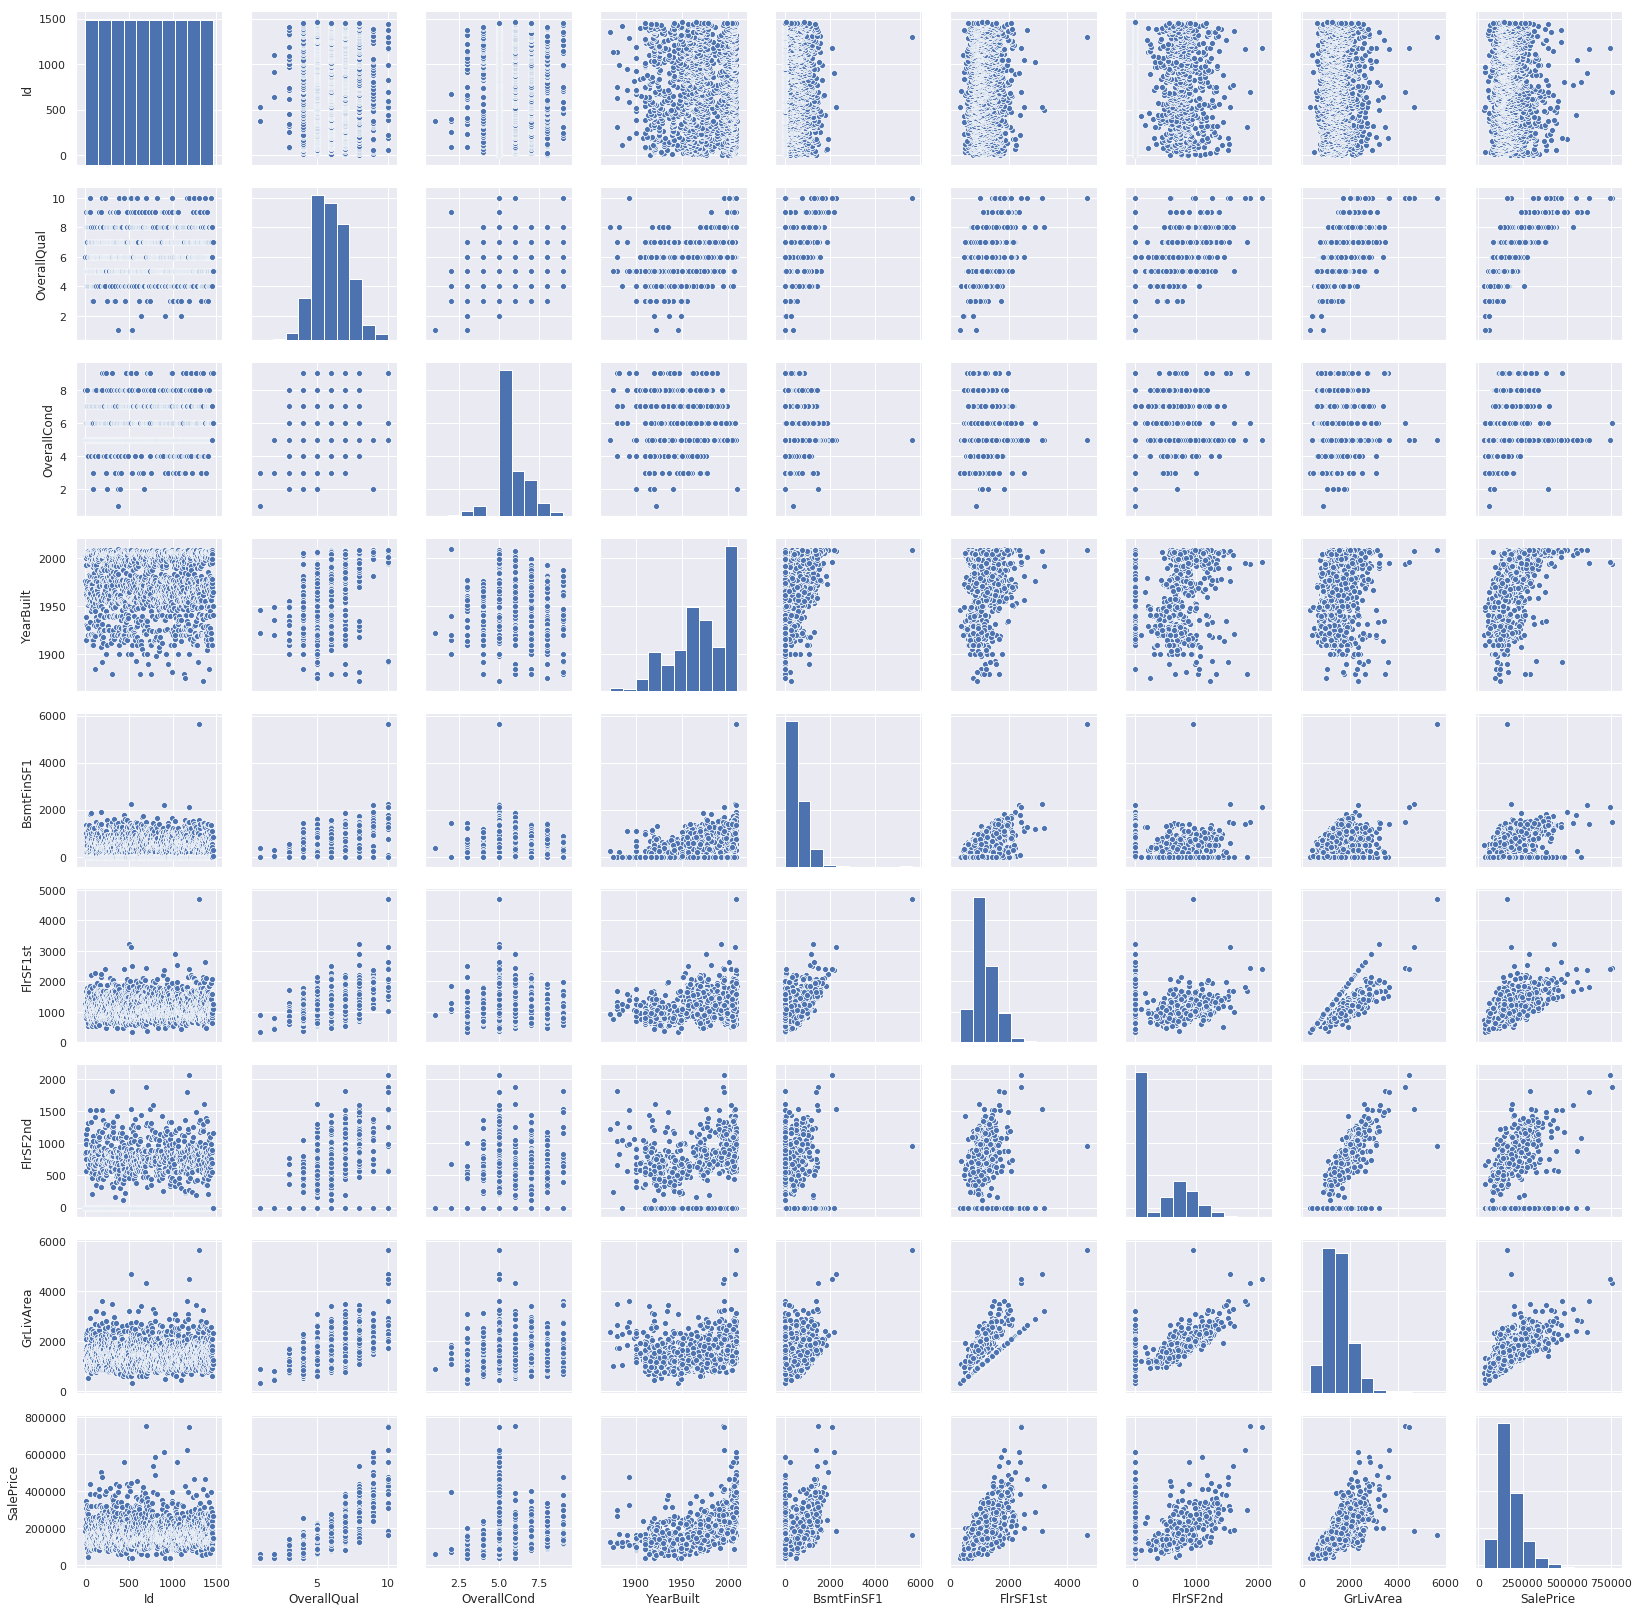

In [4]:
# ペアプロットで概要を確認
sns.pairplot(data)

<H2>3. 正規線形モデルの構築</H2>
<p>今回のデータセットは、kaggleのHouse Prices Competition (https://www.kaggle.com/c/house-prices-advanced-regression-techniques) で用いられたデータセットからの引用です。SalePriceを応答変数、その他を説明変数とします。実際のデータセットにはもっと多くの説明変数があるのですが、今回は使い勝手の良いものを選んでいます。このSalePriceを予測するモデルを作成してみましょう。（各説明変数の詳細については上記Kaggleのページを参照してください。なお、都合により、今回配布したデータセットでは "1stFlrSF" を "FlrSF1st" に、"2ndFlrSF" を "FlrSF2nd" に名称を変更しています。）</p>
<p>7つの変数があるので$2^{7}$の変数の組み合わせが考えられますが、今回はそれを全て試すのは大変なので抜粋していくつか試してみましょう。</p>

In [5]:
data = data.sort_values(by ='SalePrice')    # dataを SalePrice の昇順で並び替える（このあと散布図のグラフ表示で並び替えたデータを使いたいため）

In [6]:
# 最小二乗法を使い、説明変数：YearBuiltでモデル作成し、AICを計算・表示
model1 = smf.ols(formula='SalePrice ~ YearBuilt', data=data).fit()
print('Model-1:',model1.aic)

Model-1: 36625.70646748859


In [7]:
# 最小二乗法を使い、説明変数：OverallQualとFlrSF1stでモデル作成し、AICを計算・表示
model2 = smf.ols(formula='SalePrice ~ OverallQual + FlrSF1st', data=data).fit()
print('Model-2:',model2.aic)

Model-2: 35367.18730733775


In [8]:
# 最小二乗法を使い、説明変数：YearBuilt、OverallQualと1stFlrSFでモデル作成し、AICを計算・表示
model3 = smf.ols(formula='SalePrice ~ YearBuilt + OverallQual + FlrSF1st', data=data).fit()
print('Model-3:',model3.aic)

Model-3: 35336.629042057226


In [9]:
# 以上の3つの結果から選択すべき最適なモデルを決定し、その詳細を表示
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     1134.
Date:                Fri, 19 Jul 2019   Prob (F-statistic):               0.00
Time:                        08:06:53   Log-Likelihood:                -17664.
No. Observations:                1460   AIC:                         3.534e+04
Df Residuals:                    1456   BIC:                         3.536e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6.172e+05   8.74e+04     -7.065      0.000   -7.89e+05   -4.46e+05
YearBuilt     263.7017     46.021      5.730      0.000     173.428     353.975
OverallQual  3.407e+04   1096.577     31.065      0.000    3.19e+04    3.62e+04
FlrSF1st       60.6548      3.353     18.090      0.000      54.078      67.232
==============================================================================
Omnibus:                      527.065   Durbin-Watson:                   1.206
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12051.684
Skew:                           1.134   Prob(JB):                         0.00
Kurtosis:                      16.891   Cond. No.                     1.76e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h2>補足：予測値と実際の値の差を散布図で確認する</h2>

作成した正規線形モデルは$Y = \beta + \alpha_1 X_1 + \alpha_2 X_2 + ...$ で表現できる式を持っています。それを使うことで、目的変数の予測値を立てることが可能です。モデルが持つ `predict()` に予測させたい説明変数のデータを与えれば予測が実行されます。

参考：https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.predict.html

ここでは変数 data を予測にかけて、SalePriceの予測値を取得しましょう。

In [10]:
# 選択したモデルを用いて data を予測にかけ、SalePriceの予測値を取得
prev = model3.predict(data)

<p>予測値と実際の SalePriceを散布図に表示することで2つの差を見てみましょう。実際の SalePrice の曲線が、予測値の点の集合のほぼ中心を通っているようなグラフになるか確認してください。</p>

Text(0.5,0,"data.sort_values(by ='SalePrice')")

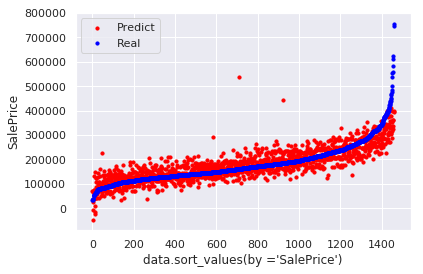

In [12]:
# 予測値と実際の SalePrice を　散布図で重ねて表示する
# （ただし、ここでは Matplotlib の scatter で散布図を描くこと。X軸は range(len(data)) を指定すればOK）
x = range(len(data))
plt.scatter(x, prev, c='red', s=10, label='Predict')
plt.scatter(x, data['SalePrice'], c='blue', s=10, label='Real')
plt.legend(loc='upper left')
plt.ylabel("SalePrice")
plt.xlabel("data.sort_values(by ='SalePrice')")